# Mounting drive



In [1]:
from google.colab import drive
from sys import path

drive.mount('/content/drive', force_remount=True)

root = '/content/drive/My Drive/nlp-lab/'
path.append(root)

amazon_en_label = 'amazon_en'
amazon_de_label = 'amazon_de'
organic_label = 'organic'

data_location = 'data/data-with-embeddings/not-contextualized-embeddings/BERT-base-multilingual-cased/'
embedding_dim = 768

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import numpy as np
import sklearn.metrics as metrics
import sklearn.model_selection as model_selection
import pandas as pd

import random
import copy
import json 

import torch
import torch.nn as nn
import torch.utils as utils
from torch import optim

from models.milnet import dataset, model, trainer

%reload_ext autoreload
%autoreload 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def read_data(label, splits):
  if label is None:
    return None

  for split in splits:
    path = root + data_location + label + f'_{split}.json'
    with open(path) as json_file:      
        data_df = json_file.read() 
        data_df = json.loads(data_df)
        yield pd.DataFrame(data_df)

In [16]:
amazon_en_df, amazon_en_test_df = read_data(amazon_en_label, ['train', 'test'])

In [5]:
amazon_de_df, = read_data(amazon_de_label, ['all'])

In [6]:
organic_df, organic_test_df = read_data(organic_label, ['train', 'test'])

In [7]:
def drop(df, column, value):
  print(f'----> size before {len(df)}')
  idx = df[column] != value
  print(f'----> size after {idx.sum()}')
  return df[idx]

drop_neutral = False

if drop_neutral:
  print('======DROPPING NEUTRAL CLASS======')
  print('amazon_en: train')
  amazon_en_train_df = drop(amazon_en_train_df, 'comment_sentiment', '0')
  print('amazon_en: test')
  amazon_en_test_df = drop(amazon_en_test_df, 'comment_sentiment', '0')
  print('amazon_de')
  amazon_de_df = drop(amazon_de_df, 'comment_sentiment', '0')
  print('organic: train')
  organic_train_df = drop(organic_train_df, 'sentence_sentiment', '0')
  print('organic: test')
  organic_test_df = drop(organic_test_df, 'sentence_sentiment', '0')

In [8]:
if drop_neutral:
  sentiment_classes = {'n': 0, 'p': 1}
  sentiment_labels = {0 : 'n', 1 : 'p'} 
else:
  sentiment_classes = {'n': 0, '0': 1, 'p': 2}
  sentiment_labels = {0 : 'n', 1 : '0', 2 : 'p'} 

last_column = str(embedding_dim - 1)

def parse_amazon_data(df, downsampling_factor=0, upsampling_factor=0):
  if df is None:
    return dataset.DocumentDataset((), ()), ()

  comments = []
  sentiments = []

  downsampled = 0
  upsampled_n = 0
  upsampled_0 = 0

  for comment_id, comment_df in df.groupby('comment_id'):
    nunique_sentiments = comment_df['comment_sentiment'].nunique()
    if (nunique_sentiments > 1):
      print('Found inconsitent sentiment'
            f'for the comment with id = {comment_id}')

    sentiment = comment_df['comment_sentiment'][0]

    if sentiment == 'p' and random.random() < downsampling_factor:
      downsampled += 1
      continue

    comments.append(torch.Tensor(comment_df.loc[:, '0':last_column].values).to(device))
    sentiments.append(sentiment_classes[sentiment])

    if sentiment in ['n', '0'] and random.random() < upsampling_factor:
      upsampled_n += sentiment == 'n'
      upsampled_0 += sentiment == '0'
      comments.append(torch.Tensor(comment_df.loc[:, '0':last_column].values).to(device))
      sentiments.append(sentiment_classes[sentiment])    
  
  print(f'down: {downsampled}, up negative: {upsampled_n}, up neutral: {upsampled_0}')

  sentiment_dataset = dataset.DocumentDataset(comments, sentiments)

  return sentiment_dataset

In [17]:
def split(train_val_set, test_size):
    train, val = model_selection.train_test_split(train_val_set,
                                                  test_size=test_size)
    return train, val

In [18]:
test_size = 0.15 / (0.15 + 0.7)
amazon_en_train_df, amazon_en_val_df = split(amazon_en_df, test_size)
# organic_train_df, organic_val_df = split(organic_df, test_size)

In [19]:
amazon_en_train_dataset = parse_amazon_data(amazon_en_train_df, 0.8, 0.5)
amazon_en_val_dataset = parse_amazon_data(amazon_en_val_df)
amazon_en_test_dataset = parse_amazon_data(amazon_en_test_df)

down: 9867, up negative: 674, up neutral: 741
down: 0, up negative: 0, up neutral: 0
down: 0, up negative: 0, up neutral: 0


In [41]:
amazon_de_test_dataset = parse_amazon_data(amazon_de_df)

down: 0, up negative: 0, up neutral: 0


In [42]:
def parse_organic_data(df):
  embeddings = torch.Tensor(df.loc[:, '0':last_column].values).to(device)
  sentiments = torch.Tensor(df['sentence_sentiment'].apply(
      lambda sentiment: sentiment_classes[sentiment])).to(device)
  out_dataset = dataset.DocumentDataset(tuple(embeddings.unsqueeze(1)),
                                        sentiments)
  return out_dataset

organic_train_dataset = parse_organic_data(organic_train_df)
organic_val_dataset = parse_organic_data(organic_val_df)
organic_test_dataset = parse_organic_data(organic_test_df)
  

In [27]:
datasets = {amazon_en_label : amazon_en_train_dataset,
            amazon_de_label: amazon_de_test_dataset,
            organic_label: organic_train_dataset}

for label, dset in datasets.items():
  print(f'len({label}) = {len(dset)}')

NameError: ignored

In [20]:
def train(milnet, train_set, val_set, batch_size, optim_params, fit_params):
  train_loader = utils.data.DataLoader(train_set, batch_size=batch_size,
                                      shuffle=True,
                                      collate_fn=prepare_batch,
                                      drop_last=True)
  val_loader = utils.data.DataLoader(val_set, batch_size=batch_size,
                                      shuffle=True,
                                      collate_fn=prepare_batch,
                                      drop_last=True)

  dataloaders = {'train': train_loader, 'val': val_loader}

  optimizer = optim.Adam(milnet.parameters(), **optim_params)
  criterion = nn.NLLLoss()

  return trainer.fit(milnet, optimizer, criterion, dataloaders, **fit_params)

In [21]:
prepare_batch = lambda batch: trainer.prepare_batch(batch, device)

params = model.MilNetParams()

params.seg_emb_dim =  embedding_dim
params.seg_hidden_dim = 300
params.hidden_dim = 50
params.gru_layers = 10
params.attention_dim = 100
params.dropout_gru = 0.2
params.dropout_att = 0.2
params.dropout_seg = 0.2
params.classes_nb = 3 - drop_neutral

In [23]:
optim_params = {'lr': 1e-3, 'weight_decay': 1e-2}
fit_params = {'nb_epochs': 50, 'patience': 50, 'print_every': 15}

milnet = model.MilNet(params, train_embeddings=False).to(device)

print("=====TRAIN ON AMAZON DATA=====")
_, amazon_train_losses, amazon_val_losses = train(milnet, amazon_en_train_dataset,
                                                  amazon_en_val_dataset,
                                                  batch_size=32,
                                                  optim_params=optim_params,
                                                  fit_params=fit_params)

torch.save(milnet.state_dict(),
           root + f'/models/milnet/state_dicts/bert_ml_no_finetune_{params.classes_nb}cl_test')

# print("=====FINETUNE ON ORGANIC DATA=====")
# _, organic_train_losses, organic_val_losses = train(milnet, organic_train_dataset,
#                                                     organic_val_dataset,
#                                                     batch_size=128,
#                                                     optim_params=optim_params,
#                                                     fit_params=fit_params)
# torch.save(milnet.state_dict(),
#            root + f'/models/milnet/state_dicts/bert_ml_{params.classes_nb}cl')

=====TRAIN ON AMAZON DATA=====
Epoch  15/50 -> train loss: 2.94e-02, accuracy: 55.51%
Epoch  15/50 -> val loss: 2.98e-02, accuracy: 58.67%
Epoch  30/50 -> train loss: 2.86e-02, accuracy: 56.68%
Epoch  30/50 -> val loss: 2.66e-02, accuracy: 61.99%
Epoch  45/50 -> train loss: 2.82e-02, accuracy: 58.54%
Epoch  45/50 -> val loss: 3.16e-02, accuracy: 52.80%


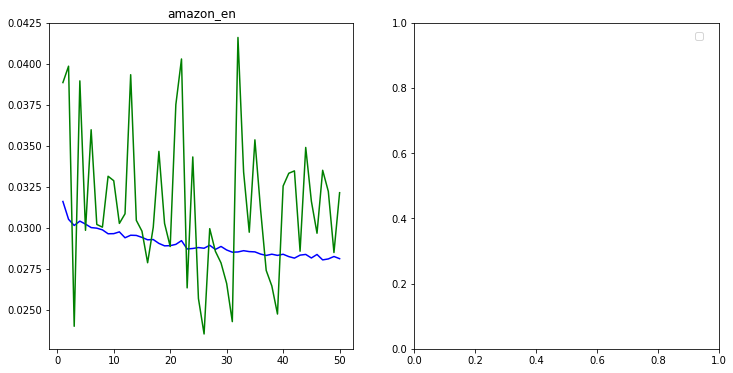

In [24]:
import matplotlib.pyplot as plt

def plot_losses(title, ax, train_losses, val_losses):
  epochs = np.arange(1, len(train_losses) + 1)
  ax.set_title(title)
  ax.plot(epochs, train_losses, color='blue', label='train')
  ax.plot(epochs, val_losses, color='green', label='validation')


fig, (ax_amazon, ax_organic) = plt.subplots(1, 2, figsize=(12,6))
plot_losses("amazon_en", ax_amazon, amazon_train_losses,
            amazon_val_losses)
# plot_losses("organic", ax_organic, organic_train_losses, organic_val_losses)

handles, labels = ax_organic.get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(0.82, 0.8))

fig.show()

In [11]:
milnet = model.MilNet(params, train_embeddings=False).to(device)
milnet.load_state_dict(torch.load(root + f'/models/milnet/state_dicts/bert_ml_no_finetune_{params.classes_nb}cl_test'))

<All keys matched successfully>

In [25]:
def get_results(test_set):
  results = []
  test_loader = utils.data.DataLoader(test_set, batch_size=len(test_set),
                                      shuffle=True,
                                      collate_fn=prepare_batch,
                                      drop_last=True)
  assert(len(test_loader) == 1)
  for documents, classes in test_loader:
    predictions = milnet(documents).cpu().numpy()
    return np.argmax(predictions, axis=1), classes.cpu().numpy()


test_datasets = {'amazon_en': amazon_en_test_dataset,}
                #  'amazon_de': amazon_de_test_dataset,
                #  'organic': organic_test_dataset}
results = {}

milnet.eval()
with torch.set_grad_enabled(False):
  for name, test_set in test_datasets.items():
    results[name] = get_results(test_set)

In [26]:
for dataset_name, (top1, labels) in results.items():
  print(f'=== {dataset_name} ===')
  print(f'F1-micro = {metrics.f1_score(labels, top1, average="micro")}')
  print(f'F1-macro = {metrics.f1_score(labels, top1, average="macro")}')
  confusion = metrics.confusion_matrix(labels, top1)
  sentiments = [sentiment_labels[i] for i in range(len(confusion))]
  row_format ="{:>6}" * (len(confusion) + 1)
  print()
  print(row_format.format("", *sentiments))
  for sentiment, row in zip(sentiments, confusion):
    print(row_format.format(sentiment, *row))
  print()

=== amazon_en ===
F1-micro = 0.7032357473035439
F1-macro = 0.4432101655558542

           n     0     p
     n   246   175   506
     0   133   286   580
     p   669   826  6314



In [15]:
np.unique(top1, return_counts=True)

(array([0, 1, 2]), array([1091,  189, 8455]))